### Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import missingno as msno

In [2]:
dataframe=pd.read_csv("data.csv",encoding="ISO-8859-1")
dataframe.head(5)

C:\Users\QT675QK\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CARDNO,OldLoyaltyID,Channel,StoreCode,INVOICE_DATE,GVCode,INVOICE_NO,LineItemNo,ItemCode,Category,...,SPENT,TIERNAME,MembershipDate,CAMPAIGNNAME,REMARKS,RewardPostingDate,NEW_CARDNO,INV_DT,CHANNEL_F,UNQ_KEY
0,7.001468e+11,NaN,EyePlus,TTBH,1012017,NaN,BTG0003067,000070,STCTRHG,EyePlus,...,0.0,Encircle Gold,27 Dec 2016,Eye Plus Std Campaign,Credit - Y,02 Jan 2017,7.001468e+11,1012017.0,EYEPLUS,EYEPLUSTTBHBTG000306701012017
1,7.001468e+11,NaN,EyePlus,TTBH,1012017,NaN,BTG0003067,000060,STCTRHG,EyePlus,...,0.0,Encircle Gold,27 Dec 2016,Eye Plus Std Campaign,Credit - Y,02 Jan 2017,7.001468e+11,1012017.0,EYEPLUS,EYEPLUSTTBHBTG000306701012017
2,7.001468e+11,NaN,EyePlus,TTBH,1012017,NaN,BTG0003067,000050,FRB0136AA,EyePlus,...,0.0,Encircle Gold,27 Dec 2016,Eye Plus Std Campaign,NaN,02 Jan 2017,7.001468e+11,1012017.0,EYEPLUS,EYEPLUSTTBHBTG000306701012017
3,7.001466e+11,NaN,Tanishq,AND,1012017,0,1977,4,512016CYKIAA00,71,...,0.0,Encircle Gold,01 Jan 2017,Tanishq Plain Gold Campaign_23,NaN,02 Jan 2017,7.001466e+11,1012017.0,ANUTTARA,ANUTTARAAND197701012017
4,7.001466e+11,NaN,Tanishq,AND,1012017,0,1977,3,511038CTEMAA00,71,...,0.0,Encircle Gold,01 Jan 2017,Tanishq Plain Gold Campaign_23,NaN,02 Jan 2017,7.001466e+11,1012017.0,ANUTTARA,ANUTTARAAND197701012017


<AxesSubplot:>

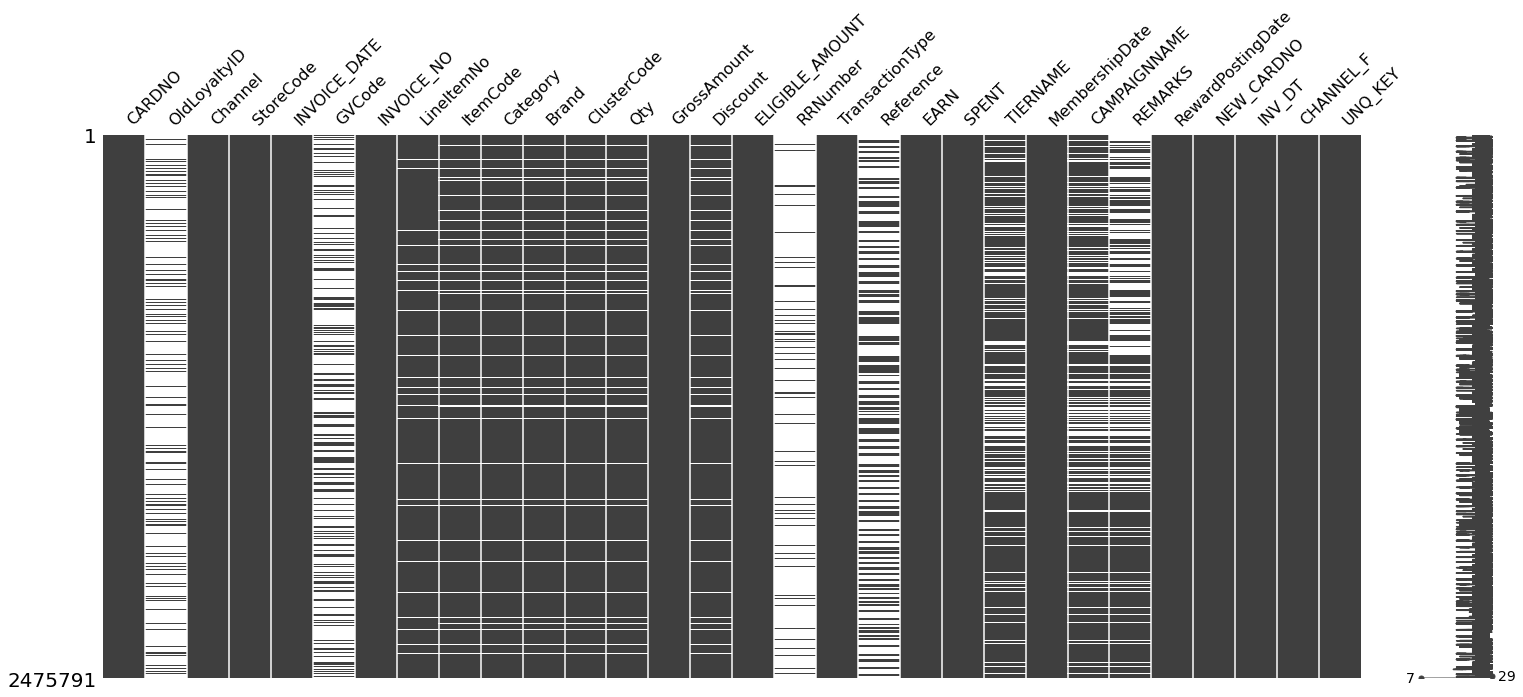

In [3]:
msno.matrix(dataframe)

### Drop unnecessary columns and missing values

In [3]:
dataframe.drop(["RRNumber","OldLoyaltyID","GVCode","Reference","REMARKS","LineItemNo","UNQ_KEY"],axis=1,inplace=True)

### Get columns in appropriate format

In [4]:
dataframe.dropna(subset=["INV_DT"],inplace=True)
#dataframe[dataframe.INV_DT.isnull()]
dataframe["INVOICE_DATE"]=dataframe["INVOICE_DATE"].astype(str)
dataframe["INV_DT"]=dataframe["INV_DT"].astype(int).astype(str)
def convert_to_date(date):
    t=date.strip()
    return t[-4:]+"-"+t[-6:-4]+"-"+t[:-6]
dataframe["INVOICE_DATE"]=dataframe["INVOICE_DATE"].apply(convert_to_date)
dataframe["INVOICE_DATE"]=pd.to_datetime(dataframe["INVOICE_DATE"])
dataframe["INV_DT"]=dataframe["INV_DT"].apply(convert_to_date)
dataframe["INV_DT"]=pd.to_datetime(dataframe["INV_DT"])

In [5]:
dataframe.dropna(subset=["MembershipDate","NEW_CARDNO","ELIGIBLE_AMOUNT"],inplace=True)

In [6]:
dataframe.MembershipDate=pd.to_datetime(dataframe["MembershipDate"])
dataframe.RewardPostingDate=pd.to_datetime(dataframe.RewardPostingDate)

### Manage missing values.

In [7]:
dataframe["ItemCode"].replace(np.NaN,"Unknown",inplace=True)
dataframe["Category"].replace(np.NaN,"Unknown",inplace=True)
dataframe["Brand"].replace(np.NaN,"Unknown",inplace=True)
dataframe["TIERNAME"].replace(np.NaN, "Without Tier",inplace=True)
dataframe["CAMPAIGNNAME"].replace(np.NaN, "Without Campaign",inplace=True)
dataframe["Qty"].replace(np.NaN,1,inplace=True)
dataframe["Discount"].replace(np.NaN,0.0,inplace=True)

# df=dataframe[dataframe["ItemCode"].isnull()]#["TransactionType"]=="Earned"]
# t=df[df["TransactionType"]=="Earned"]
# dataframe.drop(t.index,inplace=True)

dataframe["ClusterCode"].replace(np.NaN,"Missing",inplace=True)

In [8]:
dataframe["Channel"]=dataframe["Channel"].astype("category")
dataframe["TIERNAME"]=dataframe["TIERNAME"].astype("category")
dataframe["CAMPAIGNNAME"]=dataframe["CAMPAIGNNAME"].astype("category")
dataframe["CHANNEL_F"]=dataframe["CHANNEL_F"].astype("category")
dataframe["Category"]=dataframe["Category"].astype("category")
dataframe["StoreCode"]=dataframe["StoreCode"].astype("category")
dataframe["ClusterCode"]=dataframe["ClusterCode"].astype("category")
dataframe["TransactionType"]=dataframe["TransactionType"].astype("category")
dataframe["Brand"]=dataframe["Brand"].astype("category")

### Adding necessary columns.

In [9]:
dataframe['license_time'] = pd.to_datetime("now") - dataframe['MembershipDate']
dataframe['offer_time'] = pd.to_datetime("now") - dataframe['RewardPostingDate']
dataframe['license_time'] = dataframe['license_time'].apply(lambda x : x.days)
dataframe['offer_time'] = dataframe['offer_time'].apply(lambda x : x.days)

In [10]:
from datetime import timedelta

In [11]:
snapshot_date = dataframe['INVOICE_DATE'].max() + timedelta(days=1)
data_process = dataframe.groupby(['CARDNO']).agg({
        'INVOICE_DATE': lambda x: (snapshot_date - x.max()).days,
        'INVOICE_NO': 'count',
        'ELIGIBLE_AMOUNT': 'sum'})
data_process.rename(columns={'INVOICE_DATE': 'Recency',
                         'INVOICE_NO': 'Frequency',
                         'ELIGIBLE_AMOUNT': 'MonetaryValue'}, inplace=True)

In [12]:
data_process.head()#.to_excel(writer,sheet_name="RFM")

,Recency,Frequency,MonetaryValue
CARDNO,,,
7.000000e+11,30,1,0.00
7.000000e+11,75,2,12172.74
7.000000e+11,50,1,184158.30
7.000000e+11,89,5,4249.00
7.000000e+11,82,2,12660.70


C:\Users\QT675QK\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\QT675QK\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\QT675QK\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

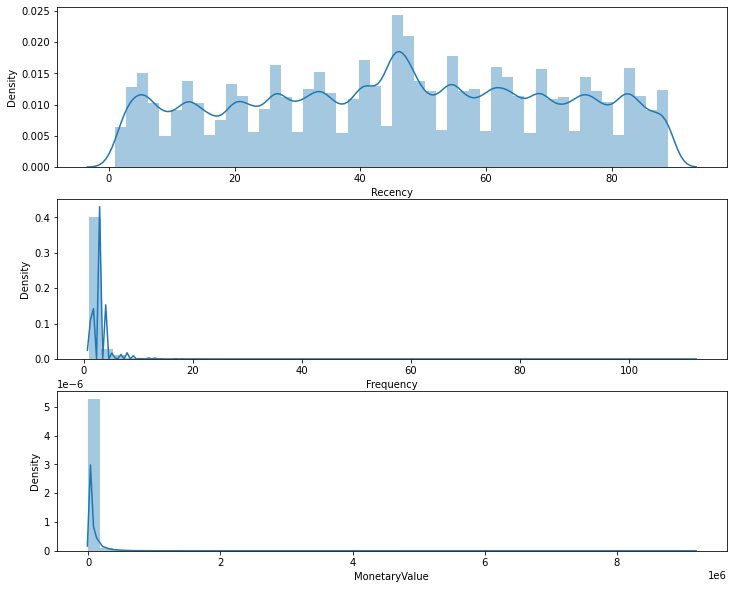

In [13]:
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [14]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'].rank(method='first'), q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()#.to_excel(writer,sheet_name="rfmrf")

,Recency,Frequency,MonetaryValue,R,F
CARDNO,,,,,
7.000000e+11,30,1,0.00,3,1
7.000000e+11,75,2,12172.74,1,3
7.000000e+11,50,1,184158.30,2,1
7.000000e+11,89,5,4249.00,1,4
7.000000e+11,82,2,12660.70,1,3


In [15]:
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [ ]:
data_process['R'].head()

In [16]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()#.to_excel(writer,sheet_name="rfm_level")

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CARDNO,,,,,,,
7.000000e+11,30,1,0.00,3,1,1,311
7.000000e+11,75,2,12172.74,1,3,3,133
7.000000e+11,50,1,184158.30,2,1,4,214
7.000000e+11,89,5,4249.00,1,4,3,143
7.000000e+11,82,2,12660.70,1,3,3,133


In [18]:
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

64


In [17]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CARDNO
7.000000e+11    5
7.000000e+11    7
7.000000e+11    7
7.000000e+11    8
7.000000e+11    7
Name: RFM_Score, dtype: int64


In [19]:
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CARDNO,,,,,,,,,
7.000000e+11,30,1,0.00,3,1,1,311,5,Promising
7.000000e+11,75,2,12172.74,1,3,3,133,7,Loyal
7.000000e+11,50,1,184158.30,2,1,4,214,7,Loyal
7.000000e+11,89,5,4249.00,1,4,3,143,8,Champions
7.000000e+11,82,2,12660.70,1,3,3,133,7,Loyal


In [20]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue        
                      mean      mean          mean   count
RFM_Level                                                 
Can't Loose Them      30.7       3.1       52857.4  423140
Champions             44.2       1.9       18914.7  199900
Loyal                 47.8       1.5       11818.7  190065
Needs Attention       70.9       1.0        1541.1   82611
Potential             52.9       1.2        8967.7  191025
Promising             62.1       1.1        2438.2  143613
Require Activation    78.3       1.0        1115.2   26614


# !pip install squarify

In [24]:
import squarify

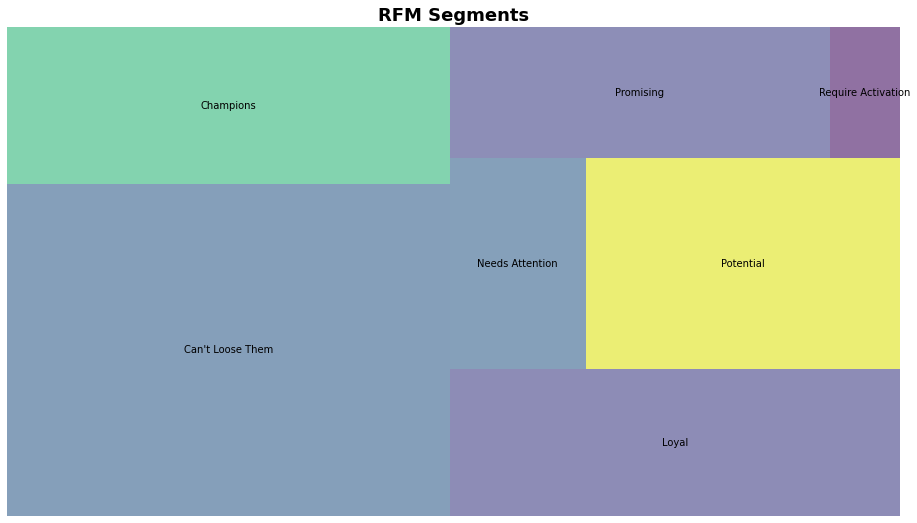

In [25]:
#rfm_level_agg.columns = rfm_level_agg.columns.droplevel(0)
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

### Cliping Outliers

In [21]:
df=dataframe.drop(["INVOICE_DATE","INVOICE_NO","ClusterCode","GrossAmount","MembershipDate",
         "RewardPostingDate"],axis=1)

In [22]:
df.drop(['NEW_CARDNO','CHANNEL_F','INV_DT'],axis=1,inplace=True)

df["MembershipDate"]=df["MembershipDate"].astype("category").cat.codes

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475789 entries, 0 to 2475789
Data columns (total 16 columns):
 #   Column           Dtype   
---  ------           -----   
 0   CARDNO           float64 
 1   Channel          category
 2   StoreCode        category
 3   ItemCode         object  
 4   Category         category
 5   Brand            category
 6   Qty              float64 
 7   Discount         float64 
 8   ELIGIBLE_AMOUNT  float64 
 9   TransactionType  category
 10  EARN             float64 
 11  SPENT            float64 
 12  TIERNAME         category
 13  CAMPAIGNNAME     category
 14  license_time     int64   
 15  offer_time       int64   
dtypes: category(7), float64(6), int64(2), object(1)
memory usage: 207.8+ MB


In [ ]:
# df.loc[:,'']=df['Category'].map(cat)

In [ ]:
df['ItemCode']=df['ItemCode'].astype("category")
cat=df.groupby('Category').size()/len(df)
#cat

In [ ]:
df.loc[:,'Catfrq']=df['Category'].map(cat)
#df

In [ ]:
br=df.groupby('Brand').size()/len(df)
#br

In [ ]:
df.loc[:,'Brdfrq']=df['Brand'].map(br)
#df

In [ ]:
it=df.groupby('ItemCode').size()/len(df)
df.loc[:,'itemfrq']=df['ItemCode'].map(it)

In [ ]:
df.drop(['ItemCode'], axis=1,inplace=True)# 'Category', 'Brand'], axis=1,inplace=True)

In [ ]:
msno.matrix(df)

In [ ]:
sc=df.groupby('StoreCode').size()/len(df)
df.loc[:,'strfrq']=df['StoreCode'].map(sc)

In [ ]:
df.drop(["StoreCode"],axis=1,inplace=True)

In [23]:
one_hot = pd.get_dummies(df['Channel'])
df = df.drop('Channel',axis = 1)
df = df.join(one_hot)

In [24]:
one_hot = pd.get_dummies(df['TransactionType'])
df = df.drop('TransactionType',axis = 1)
df = df.join(one_hot)

In [25]:
one_hot = pd.get_dummies(df['TIERNAME'])
df = df.drop('TIERNAME',axis = 1)
df = df.join(one_hot)

In [101]:
# one_hot = pd.get_dummies(df['Category'])
# df = df.drop('Category',axis = 1)
# df = pd.concat([df, one_hot], axis=1)#df.join(one_hot)
# one_hot = pd.get_dummies(df['Brand'])
# df = df.drop('Brand',axis = 1)
# df = pd.concat([df, one_hot], axis=1)#df = df.join(one_hot)
# one_hot = pd.get_dummies(df['CAMPAIGNNAME'])
# df = df.drop('CAMPAIGNNAME',axis = 1)
# df = pd.concat([df, one_hot], axis=1)#df = df.join(one_hot)

In [245]:
df1=df.groupby("CARDNO")
df2=pd.DataFrame(df1.sum()).drop(['ELIGIBLE_AMOUNT','license_time','offer_time'],axis=1)
df2

,Qty,Discount,EARN,SPENT,EyePlus,Fastrack,GoldPlus,Helios,LWOT,TAR,...,WOT,ecom,Earned,Earned Reversal,Redeemed,Redemption Reversal,Encircle Gold,Encircle Platinum,Encircle Silver,Without Tier
CARDNO,,,,,,,,,,,,,,,,,,,,,
7.000000e+11,1.0,0.0,0.00,750.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
7.000000e+11,2.0,0.0,85.21,6253.0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,2,0,0
7.000000e+11,1.0,7214.0,0.00,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7.000000e+11,5.0,0.0,42.49,396.0,0,0,0,0,0,0,...,5,0,2,0,2,1,0,0,5,0
7.000000e+11,2.0,0.0,37.98,6772.0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.001546e+11,1.0,0.0,23.95,0.0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
7.001546e+11,1.0,0.0,15.95,0.0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
7.001546e+11,1.0,0.0,21.95,0.0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [260]:
customer_df=rfm.merge(df,on='CARDNO')
customer_df

,CARDNO,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level,...,WOT,ecom,Earned,Earned Reversal,Redeemed,Redemption Reversal,Encircle Gold,Encircle Platinum,Encircle Silver,Without Tier
0,7.000000e+11,30,1,0.00,3,1,1,311,5,Promising,...,0,1,0,0,1,0,0,1,0,0
1,7.000000e+11,75,2,12172.74,1,3,3,133,7,Loyal,...,0,0,1,0,0,0,0,1,0,0
2,7.000000e+11,75,2,12172.74,1,3,3,133,7,Loyal,...,0,0,0,0,1,0,0,1,0,0
3,7.000000e+11,50,1,184158.30,2,1,4,214,7,Loyal,...,0,0,1,0,0,0,0,0,0,1
4,7.000000e+11,89,5,4249.00,1,4,3,143,8,Champions,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475784,7.001546e+11,3,1,2395.00,4,3,2,432,9,Can't Loose Them,...,1,0,1,0,0,0,0,0,1,0
2475785,7.001546e+11,3,1,1595.00,4,3,1,431,8,Champions,...,1,0,1,0,0,0,0,0,1,0
2475786,7.001546e+11,3,1,2195.00,4,3,2,432,9,Can't Loose Them,...,1,0,1,0,0,0,0,0,1,0
2475787,7.001546e+11,3,1,2345.00,4,3,2,432,9,Can't Loose Them,...,1,0,1,0,0,0,0,0,1,0


In [261]:
customer_df.drop(['R','F','M','RFM_Segment_Concat','RFM_Score','RFM_Level','Qty'],axis=1,inplace=True)

In [262]:
#customer_df.reset_index(inplace=True)
customer_df.drop(['CARDNO'],axis=1,inplace=True)

In [263]:
customer_df["Discount"]=(customer_df["Discount"]/(customer_df["Discount"]+customer_df["MonetaryValue"]))
customer_df['Discount']=customer_df['Discount'].fillna(0)

In [30]:
customer_df.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'StoreCode', 'ItemCode',
       'Category', 'Brand', 'Discount', 'ELIGIBLE_AMOUNT', 'EARN', 'SPENT',
       'CAMPAIGNNAME', 'license_time', 'offer_time', 'EyePlus', 'Fastrack',
       'GoldPlus', 'Helios', 'LWOT', 'TAR', 'Tanishq', 'WOT', 'ecom', 'Earned',
       'Earned Reversal', 'Redeemed', 'Redemption Reversal', 'Encircle Gold',
       'Encircle Platinum', 'Encircle Silver', 'Without Tier'],
      dtype='object')

In [264]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# customer_df["Qty"] = le.fit_transform(customer_df["Qty"])
#customer_df["RFM_Level"]=le.fit_transform(customer_df["RFM_Level"])
customer_df["Frequency"]=le.fit_transform(customer_df["Frequency"])
#customer_df["RFM_Score"]=le.fit_transform(customer_df["RFM_Score"])
#df["StoreCode"]=le.fit_transform(df["StoreCode"])
#df.drop(["StoreCode"])

In [251]:
df2.columns

Index(['Qty', 'Discount', 'EARN', 'SPENT', 'EyePlus', 'Fastrack', 'GoldPlus',
       'Helios', 'LWOT', 'TAR', 'Tanishq', 'WOT', 'ecom', 'Earned',
       'Earned Reversal', 'Redeemed', 'Redemption Reversal', 'Encircle Gold',
       'Encircle Platinum', 'Encircle Silver', 'Without Tier'],
      dtype='object')

In [265]:
customer_df.drop(['StoreCode','ItemCode','ELIGIBLE_AMOUNT','CAMPAIGNNAME','Category','Brand'],axis=1,inplace=True)
# one_hot = pd.get_dummies(customer_df['RFM_Level'])
# customer_df = customer_df.drop('RFM_Level',axis = 1)
# customer_df = pd.concat([customer_df, one_hot], axis=1)

In [33]:
one_hot = pd.get_dummies(customer_df['Category'])
customer_df = customer_df.drop('Category',axis = 1)
customer_df = pd.concat([customer_df, one_hot], axis=1)#df.join(one_hot)
one_hot = pd.get_dummies(customer_df['Brand'])
customer_df = customer_df.drop('Brand',axis = 1)
customer_df = pd.concat([customer_df, one_hot], axis=1)#df = df.join(one_hot)
# one_hot = pd.get_dummies(customer_df['CAMPAIGNNAME'])
# customer_df = customer_df.drop('CAMPAIGNNAME',axis = 1)
# customer_df = pd.concat([customer_df, one_hot], axis=1)#df = df.join(one_hot)

In [213]:
customer_df

,Recency,Frequency,MonetaryValue,Discount,EARN,SPENT,license_time,offer_time,EyePlus,Fastrack,...,Encircle Platinum,Encircle Silver,Without Tier,Can't Loose Them,Champions,Loyal,Needs Attention,Potential,Promising,Require Activation
0,30,0,0.00,0.000000,0.00,750.0,1616,1393,0,0,...,1,0,0,0,0,0,0,0,1,0
1,75,1,12172.74,0.000000,85.21,0.0,1598,1437,0,0,...,1,0,0,0,0,1,0,0,0,0
2,75,1,12172.74,0.000000,0.00,6253.0,1598,1438,0,0,...,1,0,0,0,0,1,0,0,0,0
3,50,0,184158.30,0.037696,0.00,0.0,1596,1412,0,0,...,0,0,1,0,0,1,0,0,0,0
4,89,4,4249.00,0.000000,0.00,396.0,1545,1452,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475784,3,0,2395.00,0.000000,23.95,0.0,1366,1365,0,0,...,0,1,0,1,0,0,0,0,0,0
2475785,3,0,1595.00,0.000000,15.95,0.0,1366,1365,0,0,...,0,1,0,0,1,0,0,0,0,0
2475786,3,0,2195.00,0.000000,21.95,0.0,1366,1365,0,0,...,0,1,0,1,0,0,0,0,0,0
2475787,3,0,2345.00,0.000000,23.45,0.0,1366,1365,0,0,...,0,1,0,1,0,0,0,0,0,0


In [235]:
customer_df["EARN"]=(customer_df["EARN"]/(customer_df["Discount"]+customer_df["MonetaryValue"]))
customer_df['EARN']=customer_df['EARN'].fillna(0)
# customer_df["SPENT"]=(customer_df["SPENT"]/(customer_df["Discount"]+customer_df["MonetaryValue"]))
# customer_df['SPENT']=customer_df['SPENT'].fillna(0)
# 
# customer_df['EARN']=customer_df['EARN'].replace(np.inf,0,inplace=True)
# customer_df['Discount']=customer_df['Discount'].replace(np.inf,0,inplace=True)

In [188]:
customer_df[customer_df["EARN"].isnull()]

,Recency,Frequency,MonetaryValue,Qty,Discount,EARN,SPENT,EyePlus,Fastrack,GoldPlus,...,WOT,ecom,Earned,Earned Reversal,Redeemed,Redemption Reversal,Encircle Gold,Encircle Platinum,Encircle Silver,Without Tier


In [266]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import time

In [267]:
columns=['MonetaryValue','Discount','EARN','SPENT','Recency','license_time','offer_time']
for col in columns:
    percentiles = customer_df[col].quantile([0.01,0.99]).values
    customer_df[col] = np.clip(customer_df[col], percentiles[0], percentiles[1])

In [37]:
customer_df
# customer_df['SPENT']=customer_df['SPENT'].replace([np.inf,-np.inf],0,inplace=True)

,Recency,Frequency,MonetaryValue,Discount,EARN,SPENT,license_time,offer_time,EyePlus,Fastrack,...,FC,FS,FT,HL,SO,TA,TI,TL,Unknown,XY
0,30,0,0.00,0.000000,0.00,750.0,1616,1393,0,0,...,0,0,0,0,0,0,0,0,1,0
1,75,1,12172.74,0.000000,85.21,0.0,1598,1437,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,1,12172.74,0.000000,0.00,900.0,1598,1438,0,0,...,0,0,0,0,0,0,0,0,1,0
3,50,0,184158.30,0.037696,0.00,0.0,1596,1412,0,0,...,0,0,0,0,0,0,0,0,0,0
4,89,4,4249.00,0.000000,0.00,396.0,1545,1451,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475784,3,0,2395.00,0.000000,23.95,0.0,1367,1365,0,0,...,0,0,0,0,0,0,1,0,0,0
2475785,3,0,1595.00,0.000000,15.95,0.0,1367,1365,0,0,...,0,0,1,0,0,0,0,0,0,0
2475786,3,0,2195.00,0.000000,21.95,0.0,1367,1365,0,0,...,0,0,1,0,0,0,0,0,0,0
2475787,3,0,2345.00,0.000000,23.45,0.0,1367,1365,0,0,...,0,0,1,0,0,0,0,0,0,0


In [216]:
customer_df.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'Discount', 'EARN', 'SPENT',
       'license_time', 'offer_time', 'EyePlus', 'Fastrack', 'GoldPlus',
       'Helios', 'LWOT', 'TAR', 'Tanishq', 'WOT', 'ecom', 'Earned',
       'Earned Reversal', 'Redeemed', 'Redemption Reversal', 'Encircle Gold',
       'Encircle Platinum', 'Encircle Silver', 'Without Tier',
       'Can't Loose Them', 'Champions', 'Loyal', 'Needs Attention',
       'Potential', 'Promising', 'Require Activation'],
      dtype='object')

In [ ]:
kmeans_kwargs = {
    "init":"random",
    #n_clusters=3,
    "n_init":10,
    "max_iter":300,
    "random_state":42
}
df.drop(['StoreCode'],axis=1,inplace=True)

In [256]:
from scipy import stats

In [257]:
customer_df["Recency"] = stats.boxcox(customer_df['Recency'])[0]
customer_df["Frequency"]=customer_df["Frequency"]+1
customer_df["Frequency"] = stats.boxcox(customer_df['Frequency'])[0]
customer_df["MonetaryValue"] = pd.Series(np.cbrt(customer_df['MonetaryValue'])).values

In [268]:
scaler = StandardScaler()
cols = ['Recency','MonetaryValue', 'EARN', 'Discount','SPENT']
features=customer_df[cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
# scaled_features = scaler.fit_transform(df1)
customer_df[cols]=features
cdf=customer_df.drop(['license_time','offer_time','SPENT','EARN'],axis=1)
#df.drop(["itemfrq"],axis=1,inplace=True)
# df.drop(["strfrq"],axis=1,inplace=True)
sse=[]
for k in range(1,11):
    t = time.time()
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cdf)
    sse.append(kmeans.inertia_)
    print(f"{k} : {kmeans.inertia_}")
    print(f"time taken in {k}th iteration {time.time() - t}")
#kmeans.fit(scaled_features)

1 : 41534011.18266819
time taken in 1th iteration 7.231959104537964
2 : 25223823.05393373
time taken in 2th iteration 14.718881368637085
3 : 18804691.08859851
time taken in 3th iteration 37.02022171020508
4 : 15542088.933363974
time taken in 4th iteration 38.24541711807251
5 : 13666715.702302251
time taken in 5th iteration 51.07675385475159
6 : 11923842.1354332
time taken in 6th iteration 65.61223816871643
7 : 10871760.582413182
time taken in 7th iteration 66.34296369552612
8 : 10049286.201868627
time taken in 8th iteration 79.78245329856873
9 : 9273532.707168149
time taken in 9th iteration 93.0854606628418
10 : 8712647.938549906
time taken in 10th iteration 118.67989492416382


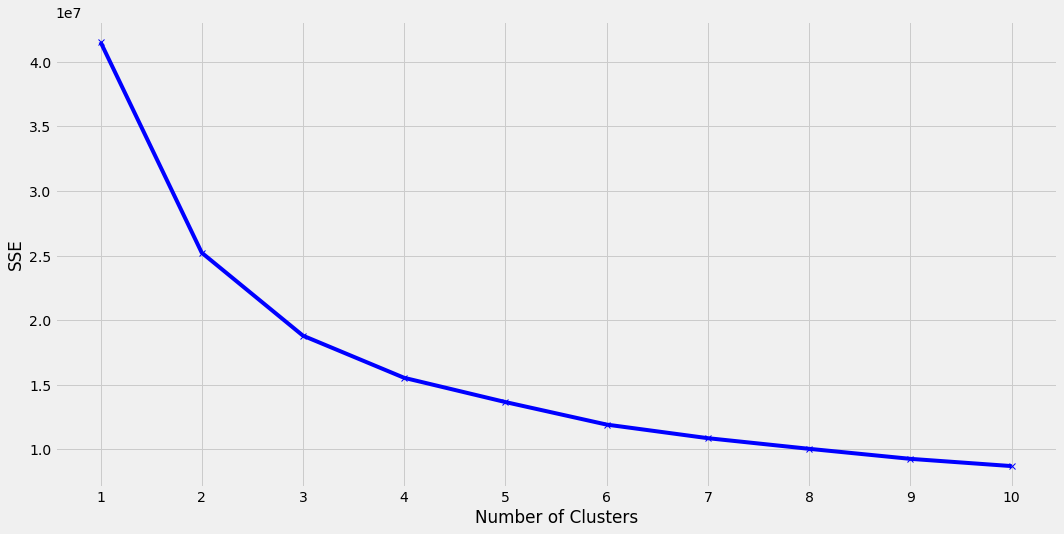

In [269]:
plt.subplots(figsize=(16,8))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse,'bx-')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [270]:
kmeans=KMeans(n_clusters=4)
kmeans.fit(cdf)

KMeans(n_clusters=4)

In [163]:
cdf.columns

Index(['Recency', 'Frequency', 'MonetaryValue', 'Discount', 'EyePlus',
       'Fastrack', 'GoldPlus', 'Helios', 'LWOT', 'TAR', 'Tanishq', 'WOT',
       'ecom', 'Earned', 'Earned Reversal', 'Redeemed', 'Redemption Reversal',
       'Encircle Gold', 'Encircle Platinum', 'Encircle Silver',
       'Without Tier'],
      dtype='object')

In [ ]:
kmeans.labels_.shape

In [ ]:
df.shape

In [271]:
labels=pd.DataFrame(kmeans.labels_)
labels

,0
0,2
1,2
2,2
3,2
4,3
...,...
2475784,2
2475785,2
2475786,2
2475787,2


In [ ]:
dataframe.shape

In [272]:
dffinal=dataframe.drop(["INVOICE_NO"],axis=1)
dffinal.dropna(subset=['ItemCode','TIERNAME'],inplace=True)

In [273]:
dffinal.reset_index(inplace=True)

In [274]:
dffinal=rfm.merge(dffinal,on='CARDNO')

In [275]:
dffinal.drop(['index'],axis=1,inplace=True)
dffinal

,CARDNO,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level,...,SPENT,TIERNAME,MembershipDate,CAMPAIGNNAME,RewardPostingDate,NEW_CARDNO,INV_DT,CHANNEL_F,license_time,offer_time
0,7.000000e+11,30,1,0.00,3,1,1,311,5,Promising,...,750.0,Encircle Platinum,2016-07-21,Points Redeemed,2017-03-01,7.000000e+11,2017-03-01,NaN,1616,1393
1,7.000000e+11,75,2,12172.74,1,3,3,133,7,Loyal,...,0.0,Encircle Platinum,2016-08-08,Tanishq Plain Gold Campaign_24,2017-01-16,7.000000e+11,2017-01-15,ANUTTARA,1598,1437
2,7.000000e+11,75,2,12172.74,1,3,3,133,7,Loyal,...,6253.0,Encircle Platinum,2016-08-08,Points Redeemed,2017-01-15,7.000000e+11,2017-01-15,ANUTTARA,1598,1438
3,7.000000e+11,50,1,184158.30,2,1,4,214,7,Loyal,...,0.0,Without Tier,2016-08-10,Without Campaign,2017-02-10,7.000000e+11,2017-02-09,ANUTTARA,1596,1412
4,7.000000e+11,89,5,4249.00,1,4,3,143,8,Champions,...,396.0,Encircle Silver,2016-09-30,Points Redeemed,2017-01-01,7.000000e+11,2017-01-01,WOT,1545,1452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475784,7.001546e+11,3,1,2395.00,4,3,2,432,9,Can't Loose Them,...,0.0,Encircle Silver,2017-03-28,WOT Std Campaign,2017-03-29,7.001546e+11,2017-03-28,WOT,1366,1365
2475785,7.001546e+11,3,1,1595.00,4,3,1,431,8,Champions,...,0.0,Encircle Silver,2017-03-28,WOT Std Campaign,2017-03-29,7.001546e+11,2017-03-28,WOT,1366,1365
2475786,7.001546e+11,3,1,2195.00,4,3,2,432,9,Can't Loose Them,...,0.0,Encircle Silver,2017-03-28,WOT Std Campaign,2017-03-29,7.001546e+11,2017-03-28,WOT,1366,1365
2475787,7.001546e+11,3,1,2345.00,4,3,2,432,9,Can't Loose Them,...,0.0,Encircle Silver,2017-03-28,WOT Std Campaign,2017-03-29,7.001546e+11,2017-03-28,WOT,1366,1365


In [276]:
dffinal=dffinal.join(labels)

In [277]:
dffinal.rename(columns={0:"cluster_label"},inplace=True)

In [278]:
cluster_1=dffinal[dffinal["cluster_label"]==0]
cluster_2=dffinal[dffinal["cluster_label"]==1]
cluster_3=dffinal[dffinal["cluster_label"]==2]
cluster_4=dffinal[dffinal["cluster_label"]==3]
# cluster_5=dffinal[dffinal["cluster_label"]==4]
# cluster_6=dffinal[dffinal["cluster_label"]==5]

In [279]:
cluster_1.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,1.513300e+05,151330.000000,151330.000000,1.513300e+05,151330.000000,151330.000000,1.513300e+05,1.513300e+05,1.513300e+05,151330.000000,151330.000000,1.513300e+05,151330.000000,151330.000000,151330.0
mean,7.000720e+11,34.004018,11.564482,2.080019e+05,10.739305,1.045946,2.172009e+04,1.764251e+03,1.832284e+04,53.166468,42.908128,7.000720e+11,2033.011650,1408.496266,0.0
std,5.051998e+07,23.675628,3.033088,3.837514e+05,1.224083,1.234290,6.003930e+04,1.068510e+04,4.860568e+04,192.768560,504.090909,5.051998e+07,512.517164,24.933243,0.0
min,7.000000e+11,1.000000,8.000000,-1.455192e-11,6.000000,1.000000,-1.131160e+05,0.000000e+00,-1.087092e+05,-3402.000000,-16753.000000,7.000000e+11,1364.000000,1363.000000,0.0
25%,7.000284e+11,13.000000,9.000000,1.396001e+04,10.000000,1.000000,6.500000e+02,0.000000e+00,4.500000e+02,0.000000,0.000000,7.000284e+11,1447.000000,1389.000000,0.0
50%,7.000576e+11,31.000000,11.000000,3.554600e+04,11.000000,1.000000,2.195000e+03,0.000000e+00,1.899800e+03,5.690000,0.000000,7.000576e+11,2054.000000,1409.000000,0.0
75%,7.001304e+11,52.000000,13.000000,2.756196e+05,12.000000,1.000000,1.429500e+04,4.300000e+02,1.181680e+04,39.000000,0.000000,7.001304e+11,2532.000000,1430.000000,0.0
max,7.001541e+11,89.000000,22.000000,9.187434e+06,12.000000,200.000000,3.985563e+06,1.187358e+06,2.538321e+06,7998.870000,26583.000000,7.001541e+11,4366.000000,1452.000000,0.0


In [280]:
cluster_2.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9747.000000,9747.0
mean,7.000783e+11,26.155022,36.078896,5.524897e+05,11.177388,1.079922,2.194638e+04,2193.853407,1.656487e+04,47.974464,49.046681,7.000783e+11,1965.953422,1408.710065,1.0
std,5.189192e+07,21.407858,16.691078,1.025371e+06,1.127165,1.469812,5.732736e+04,10107.141761,4.545863e+04,185.095270,1187.213904,5.189192e+07,505.290809,24.250608,0.0
min,7.000002e+11,1.000000,23.000000,0.000000e+00,6.000000,1.000000,-1.449500e+04,0.000000,-1.014500e+04,-2270.910000,-13000.000000,7.000002e+11,1366.000000,1363.000000,1.0
25%,7.000317e+11,8.000000,25.000000,5.172773e+04,11.000000,1.000000,1.050000e+03,0.000000,7.474000e+02,0.000000,0.000000,7.000317e+11,1446.000000,1389.000000,1.0
50%,7.000651e+11,20.000000,31.000000,1.140440e+05,12.000000,1.000000,2.495000e+03,90.000000,1.895000e+03,0.030000,0.000000,7.000651e+11,1923.000000,1409.000000,1.0
75%,7.001319e+11,42.000000,40.000000,6.618283e+05,12.000000,1.000000,1.474800e+04,652.520000,9.890000e+03,42.735000,0.000000,7.001319e+11,2497.000000,1428.000000,1.0
max,7.001505e+11,86.000000,112.000000,6.632995e+06,12.000000,99.000000,1.413394e+06,364248.000000,1.046535e+06,7569.700000,101992.000000,7.001505e+11,2899.000000,1452.000000,1.0


In [281]:
cluster_3.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1.703787e+06,1703787.0
mean,7.000974e+11,4.630602e+01,1.885745e+00,2.021341e+04,7.777795e+00,1.016852e+00,1.299029e+04,8.319336e+02,1.135012e+04,4.689651e+01,2.707820e+01,7.000974e+11,1.820611e+03,1.409140e+03,2.0
std,4.896116e+07,2.455912e+01,8.412355e-01,5.036184e+04,2.089300e+00,5.805197e-01,3.899727e+04,5.932722e+03,3.286055e+04,1.515029e+02,2.948159e+02,4.896116e+07,4.911896e+02,2.461947e+01,0.0
min,7.000000e+11,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,-2.215370e+05,0.000000e+00,-2.173996e+05,-1.741500e+03,-1.200000e+04,7.000000e+11,1.364000e+03,1.363000e+03,2.0
25%,7.000508e+11,2.700000e+01,1.000000e+00,1.906975e+03,6.000000e+00,1.000000e+00,1.125000e+03,0.000000e+00,9.990000e+02,0.000000e+00,0.000000e+00,7.000508e+11,1.412000e+03,1.389000e+03,2.0
50%,7.001241e+11,4.700000e+01,2.000000e+00,3.800000e+03,8.000000e+00,1.000000e+00,2.295000e+03,0.000000e+00,2.068000e+03,1.495000e+01,0.000000e+00,7.001241e+11,1.526000e+03,1.409000e+03,2.0
75%,7.001373e+11,6.700000e+01,3.000000e+00,1.237500e+04,9.000000e+00,1.000000e+00,7.754000e+03,2.000000e+02,6.550000e+03,3.367000e+01,0.000000e+00,7.001373e+11,2.247000e+03,1.430000e+03,2.0
max,7.001546e+11,8.900000e+01,4.000000e+00,3.692388e+06,1.200000e+01,3.000000e+02,4.625120e+06,1.329954e+06,3.295166e+06,3.254210e+04,5.290500e+04,7.001546e+11,1.074300e+04,1.452000e+03,2.0


In [282]:
cluster_4.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,6.109250e+05,610925.000000,610925.000000,6.109250e+05,610925.000000,610925.000000,6.109250e+05,6.109250e+05,6.109250e+05,610925.000000,610925.000000,6.109250e+05,610925.000000,610925.000000,610925.0
mean,7.000737e+11,40.014722,5.292913,6.971490e+04,10.054629,1.034312,1.580139e+04,1.137749e+03,1.365346e+04,49.460806,48.373900,7.000737e+11,2017.993901,1408.502371,3.0
std,4.949291e+07,24.460192,1.271052,1.429947e+05,1.418503,0.876081,4.827772e+04,7.890250e+03,3.963538e+04,174.281819,512.241353,4.949291e+07,502.505272,24.954308,0.0
min,7.000000e+11,1.000000,3.000000,-7.275958e-12,6.000000,0.000000,-3.132990e+05,0.000000e+00,-3.000031e+05,-3038.190000,-30012.000000,7.000000e+11,1364.000000,1363.000000,3.0
25%,7.000308e+11,19.000000,4.000000,5.455000e+03,9.000000,1.000000,4.500000e+02,0.000000e+00,4.250000e+02,0.000000,0.000000,7.000308e+11,1446.000000,1389.000000,3.0
50%,7.000602e+11,40.000000,5.000000,1.207000e+04,10.000000,1.000000,1.900000e+03,0.000000e+00,1.705000e+03,8.950000,0.000000,7.000602e+11,2031.000000,1409.000000,3.0
75%,7.001305e+11,60.000000,6.000000,6.742348e+04,11.000000,1.000000,9.297000e+03,2.312500e+02,7.842000e+03,37.300000,0.000000,7.001305e+11,2503.000000,1430.000000,3.0
max,7.001545e+11,89.000000,8.000000,3.692388e+06,12.000000,250.000000,3.656556e+06,1.051443e+06,1.979320e+06,27201.400000,180948.000000,7.001545e+11,4410.000000,1452.000000,3.0


In [236]:
cluster_5.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,6.394420e+05,639442.000000,639442.000000,6.394420e+05,639442.000000,639442.000000,6.394420e+05,639442.000000,639442.000000,639442.000000,639442.000000,6.394420e+05,639442.000000,639442.000000,639442.0
mean,7.000821e+11,65.194079,3.680237,1.034637e+04,8.034719,1.015743,3.978547e+03,155.766271,3325.838299,27.089810,42.944614,7.000821e+11,1948.909107,1428.367470,4.0
std,4.875236e+07,13.600975,2.302270,1.363840e+04,1.221449,0.660296,1.102526e+04,523.499222,7068.047942,61.489949,349.254124,4.875236e+07,500.677998,13.886321,0.0
min,7.000000e+11,28.000000,1.000000,-7.275958e-12,3.000000,1.000000,-2.033710e+05,0.000000,-183733.470000,-1741.500000,-16936.000000,7.000000e+11,1392.000000,1366.000000,4.0
25%,7.000381e+11,54.000000,2.000000,2.645000e+03,7.000000,1.000000,4.250000e+02,0.000000,424.800000,0.000000,0.000000,7.000381e+11,1441.000000,1417.000000,4.0
50%,7.000797e+11,65.000000,3.000000,5.154000e+03,8.000000,1.000000,1.395000e+03,0.000000,1255.000000,9.750000,0.000000,7.000797e+11,1870.000000,1429.000000,4.0
75%,7.001318e+11,76.000000,4.000000,1.180135e+04,9.000000,1.000000,3.095000e+03,85.000000,2795.000000,27.950000,0.000000,7.001318e+11,2422.000000,1440.000000,4.0
max,7.001515e+11,89.000000,44.000000,1.694727e+05,11.000000,200.000000,3.269447e+06,17035.000000,147186.880000,3600.000000,44180.000000,7.001515e+11,10743.000000,1452.000000,4.0


In [152]:
cluster_6.describe()

,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label
count,6.861700e+04,68617.000000,68617.00000,6.861700e+04,68617.000000,68617.000000,6.861700e+04,6.861700e+04,6.861700e+04,68617.000000,68617.000000,6.861700e+04,68617.000000,68617.000000,68617.0
mean,7.000713e+11,31.572832,14.90976,2.938193e+05,10.950158,1.049128,2.414118e+04,2.069277e+03,2.011127e+04,55.532856,47.167597,7.000713e+11,2039.902823,1408.534809,5.0
std,5.067921e+07,23.238586,3.62668,5.158258e+05,1.139669,0.901395,6.484306e+04,1.231461e+04,5.261629e+04,198.359363,699.293004,5.067921e+07,514.017391,24.933526,0.0
min,7.000000e+11,1.000000,11.00000,-1.455192e-11,6.000000,1.000000,-1.131160e+05,0.000000e+00,-1.087092e+05,-1666.520000,-16753.000000,7.000000e+11,1364.000000,1363.000000,5.0
25%,7.000282e+11,11.000000,12.00000,2.074400e+04,10.000000,1.000000,8.250000e+02,0.000000e+00,5.687500e+02,0.000000,0.000000,7.000282e+11,1449.000000,1389.000000,5.0
50%,7.000569e+11,28.000000,14.00000,5.850268e+04,11.000000,1.000000,2.695000e+03,0.000000e+00,2.137500e+03,4.250000,0.000000,7.000569e+11,2061.000000,1409.000000,5.0
75%,7.001304e+11,48.000000,16.00000,4.085249e+05,12.000000,1.000000,1.813600e+04,5.375000e+02,1.466868e+04,41.900000,0.000000,7.001304e+11,2541.000000,1430.000000,5.0
max,7.001541e+11,89.000000,27.00000,9.187434e+06,12.000000,105.000000,3.564835e+06,1.026514e+06,2.538321e+06,5955.000000,101992.000000,7.001541e+11,4270.000000,1452.000000,5.0


In [223]:
print(cluster_1.CARDNO.value_counts())
print(cluster_2.CARDNO.value_counts())
print(cluster_3.CARDNO.value_counts())
print(cluster_4.CARDNO.value_counts())

7.000192e+11    4
7.001462e+11    4
7.000092e+11    4
7.001208e+11    4
7.000083e+11    4
               ..
7.000385e+11    1
7.001158e+11    1
7.001497e+11    1
7.001493e+11    1
7.001467e+11    1
Name: CARDNO, Length: 1122249, dtype: int64
7.000057e+11    22
7.000033e+11    22
7.000123e+11    22
7.001340e+11    22
7.000303e+11    22
                ..
7.000695e+11     6
7.001536e+11     6
7.001297e+11     3
7.000284e+11     2
7.000252e+11     1
Name: CARDNO, Length: 13845, dtype: int64
7.001484e+11    112
7.001362e+11     94
7.001345e+11     86
7.001236e+11     83
7.000209e+11     81
               ... 
7.000354e+11     23
7.000136e+11     23
7.001346e+11     23
7.000349e+11     23
7.000069e+11     23
Name: CARDNO, Length: 308, dtype: int64
7.001375e+11    8
7.001270e+11    8
7.000306e+11    8
7.000435e+11    8
7.000654e+11    8
               ..
7.000032e+11    1
7.000005e+11    1
7.001204e+11    1
7.000278e+11    1
7.000190e+11    1
Name: CARDNO, Length: 122530, dtype: int64


<AxesSubplot:xlabel='index'>

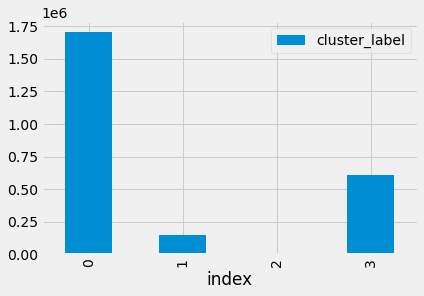

In [206]:
d=pd.DataFrame(dffinal.cluster_label.value_counts())
d=d.reset_index().sort_values('index')
d.set_index('index').plot(kind='bar')

In [238]:
print(str(cluster_1.shape)+' .. '+ str(cluster_2.shape)+' .. '+str(cluster_3.shape)+' .. '+str(cluster_4.shape)+' .. '+str(cluster_5.shape))

(660160, 34) .. (653246, 34) .. (379249, 34) .. (143692, 34) .. (639442, 34)


In [239]:
pd.DataFrame(cluster_1.Channel.value_counts())

,Channel
WOT,340885
Tanishq,135694
Fastrack,110535
EyePlus,38936
LWOT,16227
GoldPlus,10355
Helios,7208
ecom,179
TAR,141


In [240]:
pd.DataFrame(cluster_2.Channel.value_counts())

,Channel
EyePlus,319291
WOT,179817
Tanishq,84691
Fastrack,46839
GoldPlus,9344
LWOT,6955
Helios,5340
TAR,545
ecom,424


In [241]:
pd.DataFrame(cluster_3.Channel.value_counts())

,Channel
Tanishq,337965
GoldPlus,17741
WOT,11016
EyePlus,8858
Helios,1888
Fastrack,1259
LWOT,423
TAR,69
ecom,30


In [242]:
pd.DataFrame(cluster_4.Channel.value_counts())

,Channel
WOT,78019
Fastrack,24256
EyePlus,20366
Tanishq,10253
Helios,5673
LWOT,3553
GoldPlus,1564
TAR,8
ecom,0


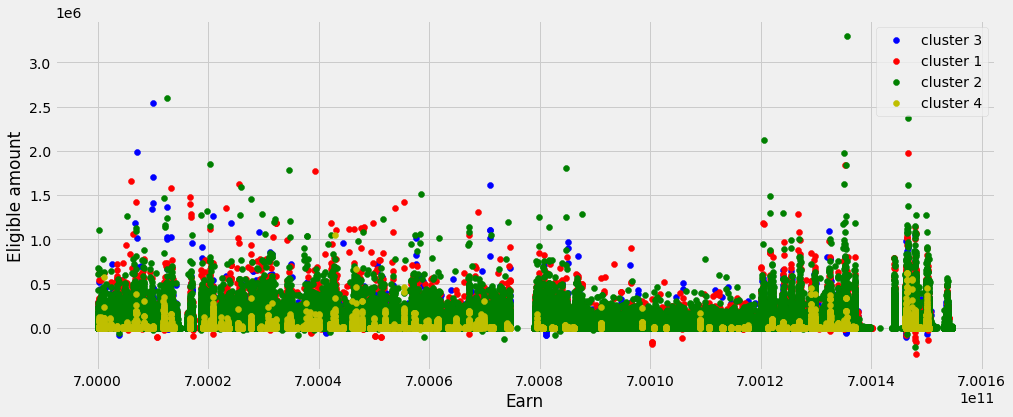

In [133]:
plt.subplots(figsize=(15,6))
plt.scatter(y=cluster_3["ELIGIBLE_AMOUNT"],x=cluster_3.CARDNO,c='b',label="cluster 3")
plt.scatter(y=cluster_1["ELIGIBLE_AMOUNT"],x=cluster_1.CARDNO,c='r',label="cluster 1")
plt.scatter(y=cluster_2["ELIGIBLE_AMOUNT"],x=cluster_2.CARDNO,c='g',label="cluster 2")
plt.scatter(y=cluster_4["ELIGIBLE_AMOUNT"],x=cluster_4.CARDNO,c='y',label="cluster 4")
plt.legend()
plt.ylabel("Eligible amount")
plt.xlabel("Earn")
plt.show()

In [ ]:
p=cluster_1["ELIGIBLE_AMOUNT"].plot()
#p=cluster_2["ELIGIBLE_AMOUNT"].plot()


In [243]:
pd.DataFrame(cluster_1.RFM_Level.value_counts())

,RFM_Level
Potential,141919
Loyal,140386
Champions,114594
Promising,104454
Can't Loose Them,71157
Needs Attention,65847
Require Activation,21803


In [244]:
pd.DataFrame(cluster_2.RFM_Level.value_counts())

,RFM_Level
Can't Loose Them,635898
Champions,17092
Loyal,256


In [245]:
pd.DataFrame(cluster_3.RFM_Level.value_counts())

,RFM_Level
Can't Loose Them,364824
Champions,11051
Loyal,2084
Potential,1290


In [246]:
pd.DataFrame(cluster_4.RFM_Level.value_counts())

,RFM_Level
Potential,31933
Promising,30292
Loyal,23045
Champions,18476
Can't Loose Them,18373
Needs Attention,16764
Require Activation,4809


In [247]:
pd.DataFrame(cluster_5.RFM_Level.value_counts())

,RFM_Level
Can't Loose Them,239107
Champions,213615
Loyal,110885
Potential,55932
Promising,19901
Require Activation,2


In [157]:
pd.DataFrame(cluster_5.RFM_Level.value_counts())

,RFM_Level
Potential,32190
Promising,30499
Loyal,23601
Can't Loose Them,20066
Champions,19618
Needs Attention,16878
Require Activation,4814


In [158]:
pd.DataFrame(cluster_6.RFM_Level.value_counts())

,RFM_Level
Can't Loose Them,67075
Champions,1153
Loyal,278
Potential,111


In [195]:
pd.DataFrame(cluster_1.CAMPAIGNNAME.value_counts())

,CAMPAIGNNAME
WOT Std Campaign,478439
Without Campaign,364690
Eye Plus Std Campaign,310477
Tanishq Plain Gold Campaign_24,164862
Fastrack New Std Campaign,151224
Points Redeemed,99066
Tanishq Plain Gold Campaign_25,49456
LWOT Std Campaign,21850
Tanishq Studded Campaign 24,13892
Helios Std Campaign,11705


In [196]:
pd.DataFrame(cluster_2.CAMPAIGNNAME.value_counts())

,CAMPAIGNNAME
Eye Plus Std Campaign,59999
Without Campaign,38041
WOT Std Campaign,14813
Tanishq Plain Gold Campaign_24,13510
Points Redeemed,10901
Reversal,3712
Tanishq Plain Gold Campaign_25,3446
Fastrack New Std Campaign,2255
Tanishq Studded Campaign 24,1047
Tanishq Plain Gold Campaign_23,808


In [197]:
pd.DataFrame(cluster_3.CAMPAIGNNAME.value_counts())

,CAMPAIGNNAME
Without Campaign,3144
WOT Std Campaign,1981
Eye Plus Std Campaign,1753
Tanishq Plain Gold Campaign_24,771
Fastrack New Std Campaign,558
Points Redeemed,501
LWOT Std Campaign,245
Tanishq Plain Gold Campaign_25,226
Reversal,212
Goldplus - Plain Gold Std Campaign_04,145


In [198]:
pd.DataFrame(cluster_4.CAMPAIGNNAME.value_counts())

,CAMPAIGNNAME
Eye Plus Std Campaign,215430
Without Campaign,121945
WOT Std Campaign,80368
Points Redeemed,65075
Tanishq Plain Gold Campaign_24,58700
Tanishq Plain Gold Campaign_25,16469
Reversal,16311
Fastrack New Std Campaign,15885
Tanishq Studded Campaign 24,4538
Tanishq Plain Gold Campaign_23,3416


In [187]:
pd.DataFrame(cluster_1.TIERNAME.value_counts())

,TIERNAME
Encircle Silver,950246
Without Tier,364690
Encircle Platinum,194434
Encircle Gold,194418


In [188]:
pd.DataFrame(cluster_2.TIERNAME.value_counts())

,TIERNAME
Encircle Platinum,48533
Encircle Silver,39644
Without Tier,38041
Encircle Gold,25130


In [189]:
pd.DataFrame(cluster_3.TIERNAME.value_counts())

,TIERNAME
Encircle Platinum,4255
Without Tier,3144
Encircle Silver,1309
Encircle Gold,1039


In [190]:
pd.DataFrame(cluster_4.TIERNAME.value_counts())

,TIERNAME
Encircle Silver,221252
Encircle Platinum,155168
Without Tier,121945
Encircle Gold,112541


In [175]:
cluster_1['earn_per']=cluster_1['EARN']/(cluster_1['Discount']+cluster_1['ELIGIBLE_AMOUNT'])
cluster_1['dis_per']=cluster_1['Discount']/(cluster_1['Discount']+cluster_1['ELIGIBLE_AMOUNT'])
cluster_1.describe()

<ipython-input-175-384aaf070272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1['earn_per']=cluster_1['EARN']/(cluster_1['Discount']+cluster_1['ELIGIBLE_AMOUNT'])
<ipython-input-175-384aaf070272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1['dis_per']=cluster_1['Discount']/(cluster_1['Discount']+cluster_1['ELIGIBLE_AMOUNT'])


,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label,earn_per,dis_per
count,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1.703788e+06,1703788.0,1.572753e+06,1.572753e+06
mean,7.000974e+11,4.630605e+01,1.885745e+00,2.021453e+04,7.777796e+00,1.016852e+00,1.299113e+04,8.321263e+02,1.135076e+04,4.689648e+01,2.707818e+01,7.000974e+11,1.820610e+03,1.409140e+03,0.0,8.468745e-03,5.910453e-02
std,4.896116e+07,2.455912e+01,8.412334e-01,5.036877e+04,2.089300e+00,5.805195e-01,3.900467e+04,5.935646e+03,3.286557e+04,1.515028e+02,2.948158e+02,4.896116e+07,4.911894e+02,2.461947e+01,0.0,7.771376e-03,1.322598e-01
min,7.000000e+11,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,-2.215370e+05,0.000000e+00,-2.173996e+05,-1.741500e+03,-1.200000e+04,7.000000e+11,1.364000e+03,1.363000e+03,0.0,-3.000000e-02,0.000000e+00
25%,7.000508e+11,2.700000e+01,1.000000e+00,1.906987e+03,6.000000e+00,1.000000e+00,1.125000e+03,0.000000e+00,9.990000e+02,0.000000e+00,0.000000e+00,7.000508e+11,1.412000e+03,1.389000e+03,0.0,2.943714e-03,0.000000e+00
50%,7.001241e+11,4.700000e+01,2.000000e+00,3.800000e+03,8.000000e+00,1.000000e+00,2.295000e+03,0.000000e+00,2.068000e+03,1.495000e+01,0.000000e+00,7.001241e+11,1.526000e+03,1.409000e+03,0.0,1.000000e-02,0.000000e+00
75%,7.001373e+11,6.700000e+01,3.000000e+00,1.237515e+04,9.000000e+00,1.000000e+00,7.755000e+03,2.000000e+02,6.550000e+03,3.367000e+01,0.000000e+00,7.001373e+11,2.247000e+03,1.430000e+03,0.0,1.000000e-02,9.906861e-02
max,7.001546e+11,8.900000e+01,4.000000e+00,3.692388e+06,1.200000e+01,3.000000e+02,4.625120e+06,1.329954e+06,3.295166e+06,3.254210e+04,5.290500e+04,7.001546e+11,1.074300e+04,1.452000e+03,0.0,3.703704e-02,1.000000e+00


In [176]:
cluster_2['earn_per']=cluster_2['EARN']/(cluster_2['Discount']+cluster_2['ELIGIBLE_AMOUNT'])
cluster_2['dis_per']=cluster_2['Discount']/(cluster_2['Discount']+cluster_2['ELIGIBLE_AMOUNT'])
cluster_2.describe()

<ipython-input-176-cf45b334182d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2['earn_per']=cluster_2['EARN']/(cluster_2['Discount']+cluster_2['ELIGIBLE_AMOUNT'])
<ipython-input-176-cf45b334182d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2['dis_per']=cluster_2['Discount']/(cluster_2['Discount']+cluster_2['ELIGIBLE_AMOUNT'])


,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label,earn_per,dis_per
count,1.513480e+05,151348.000000,151348.000000,1.513480e+05,151348.000000,151348.000000,1.513480e+05,1.513480e+05,1.513480e+05,151348.000000,151348.000000,1.513480e+05,151348.000000,151348.000000,151348.0,133914.000000,133914.000000
mean,7.000720e+11,34.004585,11.564058,2.080223e+05,10.739290,1.045940,2.172523e+04,1.764252e+03,1.832789e+04,53.177007,42.905747,7.000720e+11,2032.988424,1408.497397,1.0,0.009708,0.077925
std,5.052062e+07,23.676682,3.033156,3.837332e+05,1.224104,1.234217,6.003945e+04,1.068448e+04,4.860726e+04,192.776362,504.061474,5.052062e+07,512.517691,24.933447,0.0,0.011650,0.143516
min,7.000000e+11,1.000000,8.000000,-1.455192e-11,6.000000,1.000000,-1.131160e+05,0.000000e+00,-1.087092e+05,-3402.000000,-16753.000000,7.000000e+11,1364.000000,1363.000000,1.0,-0.030000,0.000000
25%,7.000284e+11,13.000000,9.000000,1.396499e+04,10.000000,1.000000,6.500000e+02,0.000000e+00,4.500000e+02,0.000000,0.000000,7.000284e+11,1447.000000,1389.000000,1.0,0.000000,0.000000
50%,7.000576e+11,31.000000,11.000000,3.554900e+04,11.000000,1.000000,2.195000e+03,0.000000e+00,1.899800e+03,5.690000,0.000000,7.000576e+11,2054.000000,1409.000000,1.0,0.007000,0.014776
75%,7.001304e+11,52.000000,13.000000,2.757684e+05,12.000000,1.000000,1.429525e+04,4.300000e+02,1.182739e+04,39.030000,0.000000,7.001304e+11,2532.000000,1430.000000,1.0,0.020000,0.100000
max,7.001541e+11,89.000000,22.000000,9.187434e+06,12.000000,200.000000,3.985563e+06,1.187358e+06,2.538321e+06,7998.870000,26583.000000,7.001541e+11,4366.000000,1452.000000,1.0,0.030025,1.000000


In [177]:
cluster_3['earn_per']=cluster_3['EARN']/(cluster_3['Discount']+cluster_3['ELIGIBLE_AMOUNT'])
cluster_3['dis_per']=cluster_3['Discount']/(cluster_3['Discount']+cluster_3['ELIGIBLE_AMOUNT'])
cluster_3.describe()

<ipython-input-177-0790b50d3759>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_3['earn_per']=cluster_3['EARN']/(cluster_3['Discount']+cluster_3['ELIGIBLE_AMOUNT'])
<ipython-input-177-0790b50d3759>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_3['dis_per']=cluster_3['Discount']/(cluster_3['Discount']+cluster_3['ELIGIBLE_AMOUNT'])


,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label,earn_per,dis_per
count,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9.747000e+03,9747.000000,9747.000000,9.747000e+03,9747.000000,9747.000000,9747.0,8655.000000,8655.000000
mean,7.000783e+11,26.155022,36.078896,5.524897e+05,11.177388,1.079922,2.194638e+04,2193.853407,1.656487e+04,47.974464,49.046681,7.000783e+11,1965.953422,1408.710065,2.0,0.009764,0.117688
std,5.189192e+07,21.407858,16.691078,1.025371e+06,1.127165,1.469812,5.732736e+04,10107.141761,4.545863e+04,185.095270,1187.213904,5.189192e+07,505.290809,24.250608,0.0,0.013617,0.194448
min,7.000002e+11,1.000000,23.000000,0.000000e+00,6.000000,1.000000,-1.449500e+04,0.000000,-1.014500e+04,-2270.910000,-13000.000000,7.000002e+11,1366.000000,1363.000000,2.0,-0.030000,0.000000
25%,7.000317e+11,8.000000,25.000000,5.172773e+04,11.000000,1.000000,1.050000e+03,0.000000,7.474000e+02,0.000000,0.000000,7.000317e+11,1446.000000,1389.000000,2.0,0.000000,0.000000
50%,7.000651e+11,20.000000,31.000000,1.140440e+05,12.000000,1.000000,2.495000e+03,90.000000,1.895000e+03,0.030000,0.000000,7.000651e+11,1923.000000,1409.000000,2.0,0.006998,0.043715
75%,7.001319e+11,42.000000,40.000000,6.618283e+05,12.000000,1.000000,1.474800e+04,652.520000,9.890000e+03,42.735000,0.000000,7.001319e+11,2497.000000,1428.000000,2.0,0.025500,0.149999
max,7.001505e+11,86.000000,112.000000,6.632995e+06,12.000000,99.000000,1.413394e+06,364248.000000,1.046535e+06,7569.700000,101992.000000,7.001505e+11,2899.000000,1452.000000,2.0,0.030007,1.000000


In [178]:
cluster_4['earn_per']=cluster_4['EARN']/(cluster_4['Discount']+cluster_4['ELIGIBLE_AMOUNT'])
cluster_4['dis_per']=cluster_4['Discount']/(cluster_4['Discount']+cluster_4['ELIGIBLE_AMOUNT'])
cluster_4.describe()

<ipython-input-178-192bbeebf75c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_4['earn_per']=cluster_4['EARN']/(cluster_4['Discount']+cluster_4['ELIGIBLE_AMOUNT'])
<ipython-input-178-192bbeebf75c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_4['dis_per']=cluster_4['Discount']/(cluster_4['Discount']+cluster_4['ELIGIBLE_AMOUNT'])


,CARDNO,Recency,Frequency,MonetaryValue,RFM_Score,Qty,GrossAmount,Discount,ELIGIBLE_AMOUNT,EARN,SPENT,NEW_CARDNO,license_time,offer_time,cluster_label,earn_per,dis_per
count,6.109060e+05,610906.000000,610906.000000,6.109060e+05,610906.000000,610906.000000,6.109060e+05,6.109060e+05,6.109060e+05,610906.000000,610906.000000,6.109060e+05,610906.000000,610906.000000,610906.0,519482.000000,519482.000000
mean,7.000737e+11,40.014668,5.292840,6.970275e+04,10.054612,1.034313,1.579761e+04,1.137193e+03,1.365027e+04,49.458167,48.374730,7.000737e+11,2018.002045,1408.502012,3.0,0.009827,0.068751
std,4.949262e+07,24.459950,1.270978,1.429812e+05,1.418503,0.876094,4.826058e+04,7.884251e+03,3.962294e+04,174.279182,512.249176,4.949262e+07,502.504670,24.954256,0.0,0.010442,0.138153
min,7.000000e+11,1.000000,3.000000,-7.275958e-12,6.000000,0.000000,-3.132990e+05,0.000000e+00,-3.000031e+05,-3038.190000,-30012.000000,7.000000e+11,1364.000000,1363.000000,3.0,-0.030000,0.000000
25%,7.000308e+11,19.000000,4.000000,5.455000e+03,9.000000,1.000000,4.500000e+02,0.000000e+00,4.250000e+02,0.000000,0.000000,7.000308e+11,1446.000000,1389.000000,3.0,0.000000,0.000000
50%,7.000602e+11,40.000000,5.000000,1.207000e+04,10.000000,1.000000,1.900000e+03,0.000000e+00,1.705000e+03,8.950000,0.000000,7.000602e+11,2031.000000,1409.000000,3.0,0.009000,0.000000
75%,7.001305e+11,60.000000,6.000000,6.739499e+04,11.000000,1.000000,9.295000e+03,2.312500e+02,7.839603e+03,37.290000,0.000000,7.001305e+11,2503.000000,1430.000000,3.0,0.018000,0.100000
max,7.001545e+11,89.000000,8.000000,3.692388e+06,12.000000,250.000000,3.656556e+06,1.051443e+06,1.979320e+06,27201.400000,180948.000000,7.001545e+11,4410.000000,1452.000000,3.0,0.030040,1.000000


In [ ]:
for card in dataframe['CARDNO']:
    print(card)